In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import tensorflow as tf
import keras_tuner as kt
from keras.layers import LSTM, Dense, Dropout
from keras import Sequential
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import datetime as dt

## Step 1

## 1. a

Let us download the data for the Titan stock

In [6]:
stock_data = yf.Ticker("TITAN.NS").history(start="2017-01-01", end="2024-12-31")

In [7]:
stock_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-01-02 00:00:00+05:30,315.502617,322.552127,312.193640,320.298218,656084,0.0,0.0
2017-01-03 00:00:00+05:30,327.060020,340.104062,325.285642,333.917725,2773103,0.0,0.0
2017-01-04 00:00:00+05:30,336.075709,347.153565,334.924782,344.947571,2371009,0.0,0.0
2017-01-05 00:00:00+05:30,345.762881,346.722002,340.919335,343.413025,1187872,0.0,0.0
2017-01-06 00:00:00+05:30,344.324119,348.160599,338.185756,340.679474,1089982,0.0,0.0
...,...,...,...,...,...,...,...
2024-12-23 00:00:00+05:30,3378.100098,3406.300049,3336.649902,3396.949951,691202,0.0,0.0
2024-12-24 00:00:00+05:30,3385.350098,3419.000000,3338.199951,3353.399902,485245,0.0,0.0
2024-12-26 00:00:00+05:30,3365.000000,3371.850098,3312.649902,3323.050049,637094,0.0,0.0


In [8]:
stock_data.head() #first look at the data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-01-02 00:00:00+05:30,315.502617,322.552127,312.193640,320.298218,656084,0.0,0.0
2017-01-03 00:00:00+05:30,327.060020,340.104062,325.285642,333.917725,2773103,0.0,0.0
2017-01-04 00:00:00+05:30,336.075709,347.153565,334.924782,344.947571,2371009,0.0,0.0
2017-01-05 00:00:00+05:30,345.762881,346.722002,340.919335,343.413025,1187872,0.0,0.0
2017-01-06 00:00:00+05:30,344.324119,348.160599,338.185756,340.679474,1089982,0.0,0.0


Let us consider the closing prices for the analysis and model building to follow.

In [10]:
stock_prices = stock_data["Close"]

Let us perform some exploratory analysis on the closing prices.

In [12]:
stock_prices.describe() #summary statistics

count    1974.000000
mean     1777.024131
std      1020.301015
min       320.298218
25%       905.107635
50%      1420.720825
75%      2562.747803
max      3854.039062
Name: Close, dtype: float64

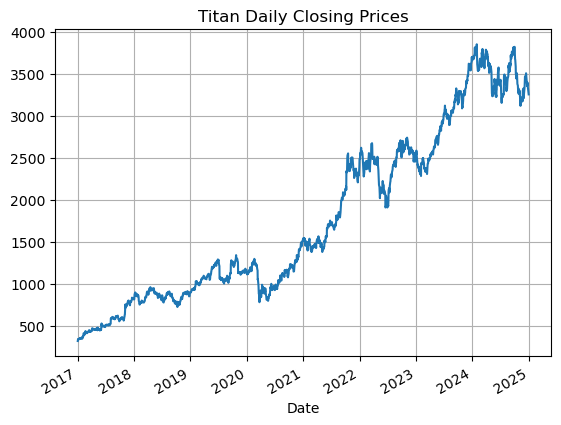

In [13]:
stock_prices.plot()
plt.title("Titan Daily Closing Prices")
plt.grid()

Despite some prices corrections, there appears to be a general rising trend in this stock over the years

Let us now look at the skew and kurtosis.

In [16]:
stock_prices.skew()

0.47883964259408673

In [17]:
stock_prices.kurtosis()

-1.1356475414778917

Let us now check for stationarity

In [19]:
adf_result = adfuller(stock_prices)
adf_statistic = adf_result[0] 
p_value = adf_result[1]
used_lags = adf_result[2] 
critical_values = adf_result[4] 

adf_statistic, p_value, used_lags, critical_values

(-0.6927549235219777,
 0.8486172611086984,
 4,
 {'1%': -3.433675467561267,
  '5%': -2.863008999826203,
  '10%': -2.5675520348463654})

The series is not stationary, as the p-value is greater than 0.05. The ADF statistic is also higher than all critical values.

Let us check for the presence of persistence in the series

In [22]:
for i in [1, 5, 10, 50, 100, 200, 500, 1000]:
    print(stock_prices.autocorr(lag = i))

0.9995098501205064
0.9974090942066507
0.9948802704267051
0.976384633231201
0.9581783390279922
0.9292831693719498
0.9138901419360034
0.8339297724685141


Clearly, high autocorrelation is present in the stock.

Text(0.5, 1.0, 'Histogram of Titan Closing Prices')

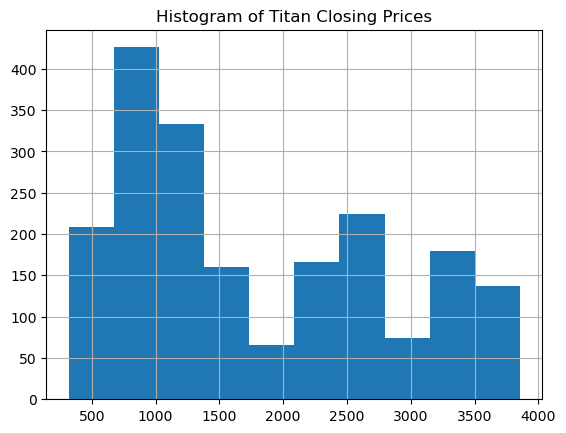

In [24]:
stock_prices.hist()
plt.title("Histogram of Titan Closing Prices")

Let us try to build predictive models on this dataset to predict future prices

Suppose we consider that data before 2023 should be used for training, and data 2023 onwards for testing, we get a 75:25 train-test split. We would have 1484 data points in the train set, and 490 in the test set.

In [27]:
train = stock_prices[stock_prices.index<"2023-01-01"]
test = stock_prices[stock_prices.index>"2023-01-01"]

In [28]:
len(train)/(len(train)+len(test))

0.75177304964539

In [29]:
len(train)

1484

In [31]:
len(test)

490

## 1. b and 1. c

Now, let us build models to forecast future prices of this stock. Here, there will be some leakage of data between the train and test data sets. I ensure data leakage in the following ways:
1. I scale the entire data before splitting it into train and test sets.
2. I use random shuffling in when performing cross-validation during training.

In [46]:
scaler = MinMaxScaler()
stock_prices_scaled = scaler.fit_transform(stock_prices.to_frame())

In [48]:
stock_prices_scaled

array([[0.        ],
       [0.00385413],
       [0.00697543],
       ...,
       [0.84973742],
       [0.84581803],
       [0.83114524]])

Now, the train-test split happens. Here, I use the train-test ratio described just a few cells above to achieve a 75:25 chronological split.

In [51]:
train_scaled = stock_prices_scaled[:1484]
test_scaled = stock_prices_scaled[1484:]

In [53]:
len(train_scaled)

1484

In [55]:
len(test_scaled)

490

First, I build an MLP model.

In [58]:
train_scaled = pd.DataFrame(train_scaled)
train_scaled.columns = ['Close']
test_scaled = pd.DataFrame(test_scaled)
test_scaled.columns = ['Close']

In [60]:
train_scaled

,Close
0,0.000000
1,0.003854
2,0.006975
3,0.006541
4,0.005768
...,...
1479,0.604554
1480,0.610844
1481,0.632307
1482,0.624770


<Axes: >

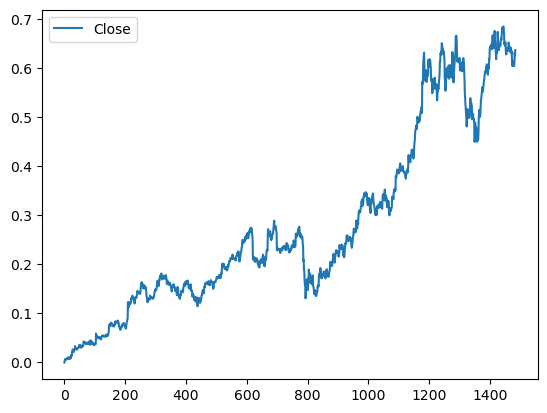

In [62]:
train_scaled.plot()

Let us build the features as well as the target for the model. Let the target be the price for the next day. Since the time series has autocorrelation and persistence, I will try to use values from the immediate past few days to predict the prices on the next day. Information from previous days will be incorporated using moving averages.

In [65]:
train_scaled["1d_lag"] = train_scaled["Close"].shift(1)
train_scaled["2d_mva"] = train_scaled["Close"].rolling(2).mean()
train_scaled["5d_mva"] = train_scaled["Close"].rolling(5).mean()
train_scaled["7d_mva"] = train_scaled["Close"].rolling(7).mean()
train_scaled["10d_mva"] = train_scaled["Close"].rolling(10).mean()
train_scaled["20d_mva"] = train_scaled["Close"].rolling(10).mean()
train_scaled["Target"] = train_scaled["Close"].shift(-1)
train_scaled

,Close,1d_lag,2d_mva,5d_mva,7d_mva,10d_mva,20d_mva,Target
0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.003854
1,0.003854,0.000000,0.001927,NaN,NaN,NaN,NaN,0.006975
2,0.006975,0.003854,0.005415,NaN,NaN,NaN,NaN,0.006541
3,0.006541,0.006975,0.006758,NaN,NaN,NaN,NaN,0.005768
4,0.005768,0.006541,0.006154,0.004628,NaN,NaN,NaN,0.005605
...,...,...,...,...,...,...,...,...
1479,0.604554,0.605100,0.604827,0.606762,0.607830,0.613751,0.613751,0.610844
1480,0.610844,0.604554,0.607699,0.606504,0.608659,0.611724,0.611724,0.632307
1481,0.632307,0.610844,0.621576,0.611578,0.610994,0.611417,0.611417,0.624770
1482,0.624770,0.632307,0.628539,0.615515,0.612800,0.612273,0.612273,0.637169


Now, let us drop all null values

In [68]:
train_scaled.dropna(inplace=True)

In [70]:
train_scaled

,Close,1d_lag,2d_mva,5d_mva,7d_mva,10d_mva,20d_mva,Target
9,0.006623,0.008075,0.007349,0.007008,0.006764,0.005818,0.005818,0.007844
10,0.007844,0.006623,0.007233,0.007456,0.006950,0.006602,0.006602,0.007057
11,0.007057,0.007844,0.007450,0.007374,0.007134,0.006923,0.006923,0.008970
12,0.008970,0.007057,0.008014,0.007714,0.007615,0.007122,0.007122,0.010517
13,0.010517,0.008970,0.009744,0.008202,0.008051,0.007520,0.007520,0.007260
...,...,...,...,...,...,...,...,...
1478,0.605100,0.605086,0.605093,0.609043,0.609495,0.616653,0.616653,0.604554
1479,0.604554,0.605100,0.604827,0.606762,0.607830,0.613751,0.613751,0.610844
1480,0.610844,0.604554,0.607699,0.606504,0.608659,0.611724,0.611724,0.632307
1481,0.632307,0.610844,0.621576,0.611578,0.610994,0.611417,0.611417,0.624770


Now, to build the MLP

In [73]:
tf.keras.backend.clear_session()  # We clear the backend to reset the random seed process
tf.random.set_seed(42)

act_fun = "relu"
hp_units_1 = 32
hp_units_2 = 64
hp_units_3 = 64
hp_units_4 = 16
#n_dropout = 0.2

In [74]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=hp_units_1, activation=act_fun, input_shape=(7,)))
#model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=hp_units_2, activation=act_fun))
#model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=hp_units_3, activation=act_fun))
#model.add(tf.keras.layers.Dropout(n_dropout)
model.add(tf.keras.layers.Dense(units=hp_units_4, activation=act_fun))
model.add(tf.keras.layers.Dense(units=1)) #activation function

C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [77]:
hp_lr = 1e-4  # Learning rate
adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)  # Adam optimizer
model.compile(optimizer=adam, loss="mse", metrics=["mae"])

In [79]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    verbose=1,
    patience=20,
    restore_best_weights=True,
)

In [81]:
X_train_scaled = train_scaled[['Close', '1d_lag', '2d_mva', '5d_mva', '7d_mva', '10d_mva', '20d_mva']]
y_train_scaled = train_scaled[['Target']]	

In [83]:
history = model.fit(
    X_train_scaled,
    y_train_scaled,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=2,
    callbacks = [es],
)

Epoch 1/100
37/37 - 3s - 88ms/step - loss: 0.0373 - mae: 0.1653 - val_loss: 0.1921 - val_mae: 0.4361
Epoch 2/100
37/37 - 0s - 12ms/step - loss: 0.0165 - mae: 0.1032 - val_loss: 0.0941 - val_mae: 0.3047
Epoch 3/100
37/37 - 0s - 8ms/step - loss: 0.0057 - mae: 0.0561 - val_loss: 0.0408 - val_mae: 0.1998
Epoch 4/100
37/37 - 0s - 8ms/step - loss: 0.0018 - mae: 0.0297 - val_loss: 0.0176 - val_mae: 0.1301
Epoch 5/100
37/37 - 0s - 8ms/step - loss: 7.9321e-04 - mae: 0.0203 - val_loss: 0.0091 - val_mae: 0.0927
Epoch 6/100
37/37 - 0s - 7ms/step - loss: 4.5823e-04 - mae: 0.0156 - val_loss: 0.0055 - val_mae: 0.0707
Epoch 7/100
37/37 - 0s - 8ms/step - loss: 2.6219e-04 - mae: 0.0113 - val_loss: 0.0034 - val_mae: 0.0549
Epoch 8/100
37/37 - 0s - 7ms/step - loss: 1.5096e-04 - mae: 0.0078 - val_loss: 0.0021 - val_mae: 0.0420
Epoch 9/100
37/37 - 0s - 7ms/step - loss: 1.1521e-04 - mae: 0.0067 - val_loss: 0.0014 - val_mae: 0.0335
Epoch 10/100
37/37 - 0s - 6ms/step - loss: 1.0156e-04 - mae: 0.0064 - val_loss

In [85]:
train_pred = model.predict(X_train_scaled)
r2_score(y_train_scaled, train_pred)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


0.9972610473632812

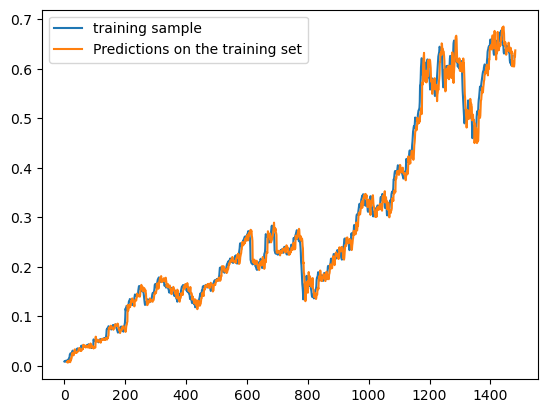

In [87]:
plt.plot(train_pred, label="training sample")
plt.plot(y_train_scaled, label="Predictions on the training set")
plt.legend()

Now, we test the model

In [89]:
test_scaled["1d_lag"] = test_scaled["Close"].shift(1)
test_scaled["2d_mva"] = test_scaled["Close"].rolling(2).mean()
test_scaled["5d_mva"] = test_scaled["Close"].rolling(5).mean()
test_scaled["7d_mva"] = test_scaled["Close"].rolling(7).mean()
test_scaled["10d_mva"] = test_scaled["Close"].rolling(10).mean()
test_scaled["20d_mva"] = test_scaled["Close"].rolling(10).mean()
test_scaled["Target"] = test_scaled["Close"].shift(-1)
test_scaled

,Close,1d_lag,2d_mva,5d_mva,7d_mva,10d_mva,20d_mva,Target
0,0.628272,NaN,NaN,NaN,NaN,NaN,NaN,0.641680
1,0.641680,0.628272,0.634976,NaN,NaN,NaN,NaN,0.637183
2,0.637183,0.641680,0.639431,NaN,NaN,NaN,NaN,0.627250
3,0.627250,0.637183,0.632216,NaN,NaN,NaN,NaN,0.620525
4,0.620525,0.627250,0.623887,0.630982,NaN,NaN,NaN,0.605548
...,...,...,...,...,...,...,...,...
485,0.870650,0.859133,0.864891,0.866875,0.874145,0.878862,0.878862,0.858326
486,0.858326,0.870650,0.864488,0.863892,0.867861,0.875400,0.875400,0.849737
487,0.849737,0.858326,0.854032,0.859430,0.863206,0.871154,0.871154,0.845818
488,0.845818,0.849737,0.847778,0.856733,0.859288,0.867290,0.867290,0.831145


In [91]:
test_scaled.dropna(inplace=True)

In [93]:
test_scaled

,Close,1d_lag,2d_mva,5d_mva,7d_mva,10d_mva,20d_mva,Target
9,0.586649,0.594887,0.590768,0.596067,0.604015,0.613524,0.613524,0.583469
10,0.583469,0.586649,0.585059,0.591651,0.597761,0.609044,0.609044,0.584057
11,0.584057,0.583469,0.583763,0.588274,0.592551,0.603282,0.603282,0.588583
12,0.588583,0.584057,0.586320,0.587529,0.590128,0.598422,0.598422,0.577641
13,0.577641,0.588583,0.583112,0.584080,0.586799,0.593461,0.593461,0.573788
...,...,...,...,...,...,...,...,...
484,0.859133,0.859302,0.859217,0.869210,0.876118,0.880879,0.880879,0.870650
485,0.870650,0.859133,0.864891,0.866875,0.874145,0.878862,0.878862,0.858326
486,0.858326,0.870650,0.864488,0.863892,0.867861,0.875400,0.875400,0.849737
487,0.849737,0.858326,0.854032,0.859430,0.863206,0.871154,0.871154,0.845818


In [95]:
X_test_scaled = test_scaled[['Close', '1d_lag', '2d_mva', '5d_mva', '7d_mva', '10d_mva', '20d_mva']]
y_test_scaled = test_scaled[['Target']]	

In [97]:
y_test_scaled

,Target
9,0.583469
10,0.584057
11,0.588583
12,0.577641
13,0.573788
...,...
484,0.870650
485,0.858326
486,0.849737
487,0.845818


In [99]:
y_pred = model.predict(X_test_scaled)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [101]:
r2_score(y_test_scaled, y_pred)

0.9162834286689758

In [103]:
y_test_og_scale = scaler.inverse_transform(y_test_scaled)
y_pred_og_scale = scaler.inverse_transform(y_pred)

Text(0.5, 1.0, 'MLP Model with Leakage - Titan Price Predictions')

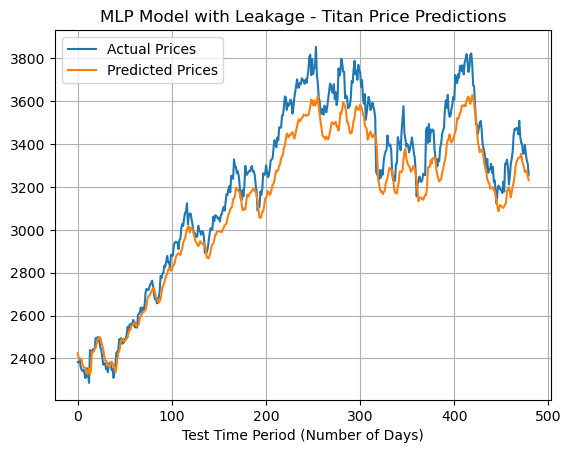

In [105]:
plt.plot(y_test_og_scale, label="Actual Prices")
plt.plot(y_pred_og_scale,label="Predicted Prices")
plt.legend()
plt.grid()
plt.xlabel("Test Time Period (Number of Days)")
plt.title("MLP Model with Leakage - Titan Price Predictions")

The r2 score on the test data is 0.92, which is impressive. But of course, there is plenty of data leakage here.

Now, I build an LSTM Model with data leakage.

In [110]:
train_scaled

,Close,1d_lag,2d_mva,5d_mva,7d_mva,10d_mva,20d_mva,Target
9,0.006623,0.008075,0.007349,0.007008,0.006764,0.005818,0.005818,0.007844
10,0.007844,0.006623,0.007233,0.007456,0.006950,0.006602,0.006602,0.007057
11,0.007057,0.007844,0.007450,0.007374,0.007134,0.006923,0.006923,0.008970
12,0.008970,0.007057,0.008014,0.007714,0.007615,0.007122,0.007122,0.010517
13,0.010517,0.008970,0.009744,0.008202,0.008051,0.007520,0.007520,0.007260
...,...,...,...,...,...,...,...,...
1478,0.605100,0.605086,0.605093,0.609043,0.609495,0.616653,0.616653,0.604554
1479,0.604554,0.605100,0.604827,0.606762,0.607830,0.613751,0.613751,0.610844
1480,0.610844,0.604554,0.607699,0.606504,0.608659,0.611724,0.611724,0.632307
1481,0.632307,0.610844,0.621576,0.611578,0.610994,0.611417,0.611417,0.624770


For this model, I will use the sequence of past 25 days data to predict future values (which is similar to the approach I followed in GWP2)

In [113]:
train_scaled = train_scaled["Close"]
test_scaled = test_scaled["Close"]

In [115]:
test_scaled

9      0.586649
10     0.583469
11     0.584057
12     0.588583
13     0.577641
         ...   
484    0.859133
485    0.870650
486    0.858326
487    0.849737
488    0.845818
Name: Close, Length: 480, dtype: float64

In [117]:
window_size = 25

In [119]:
X_train_scaled = []
y_train_scaled = [] 

X_test_scaled = []
y_test_scaled = [] 

for i in range(window_size, train_scaled.shape[0]):
    X_train_scaled.append(train_scaled[i-window_size: i])
    y_train_scaled.append(train_scaled[i])

for i in range(window_size, test_scaled.shape[0]):
    X_test_scaled.append(test_scaled[i-window_size: i])
    y_test_scaled.append(test_scaled[i])

#x_train, y_train = np.array(x_train), np.array(y_train) 

In [121]:
X_train_scaled, y_train_scaled = np.array(X_train_scaled), np.array(y_train_scaled) 
X_test_scaled, y_test_scaled = np.array(X_test_scaled), np.array(y_test_scaled)

In [123]:
seed = 42
n_dropout = 0
model = Sequential()
model.add(
    LSTM(
        units=128,
        return_sequences=True,
        activation="relu",
        input_shape=(X_train_scaled.shape[1], 1),
    )
)

C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Now, I build the LSTM model

In [126]:
model.add(LSTM(units=256, return_sequences=True, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(LSTM(units=128, return_sequences=True, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(LSTM(units=64, return_sequences=False, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(Dense(64))
model.add(Dense(1))

In [128]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 25, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 25, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 25, 128)             │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 711,553 (2.71 MB)

 Trainable params: 711,553 (2.71 MB)

 Non-trainable params: 0 (0.00 B)

In [130]:
hp_lr = 1e-4
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), loss="mean_absolute_error"
)

es = EarlyStopping(
    monitor="val_loss", mode="min", verbose=0, patience=15, restore_best_weights=True
)

# fit the models
model.fit(
    X_train_scaled,
    y_train_scaled,
    validation_split=0.15,
    epochs=100,
    batch_size=64,
    verbose=2,
    callbacks=[es],
)

Epoch 1/100
20/20 - 13s - 654ms/step - loss: 0.1510 - val_loss: 0.1480
Epoch 2/100
20/20 - 3s - 158ms/step - loss: 0.0544 - val_loss: 0.1068
Epoch 3/100
20/20 - 3s - 161ms/step - loss: 0.0210 - val_loss: 0.0361
Epoch 4/100
20/20 - 3s - 160ms/step - loss: 0.0127 - val_loss: 0.0177
Epoch 5/100
20/20 - 3s - 168ms/step - loss: 0.0098 - val_loss: 0.0228
Epoch 6/100
20/20 - 3s - 160ms/step - loss: 0.0088 - val_loss: 0.0179
Epoch 7/100
20/20 - 3s - 160ms/step - loss: 0.0086 - val_loss: 0.0187
Epoch 8/100
20/20 - 3s - 160ms/step - loss: 0.0085 - val_loss: 0.0181
Epoch 9/100
20/20 - 3s - 159ms/step - loss: 0.0083 - val_loss: 0.0185
Epoch 10/100
20/20 - 3s - 160ms/step - loss: 0.0081 - val_loss: 0.0177
Epoch 11/100
20/20 - 3s - 161ms/step - loss: 0.0079 - val_loss: 0.0156
Epoch 12/100
20/20 - 3s - 160ms/step - loss: 0.0080 - val_loss: 0.0169
Epoch 13/100
20/20 - 3s - 160ms/step - loss: 0.0076 - val_loss: 0.0175
Epoch 14/100
20/20 - 3s - 160ms/step - loss: 0.0075 - val_loss: 0.0146
Epoch 15/100
2

In [132]:
train_pred = model.predict(X_train_scaled)
print("r2 score of the model on the in-sample set:", r2_score(y_train_scaled, train_pred))
print("correlation between the predicted values and the actual in-sample data:", np.corrcoef(y_train_scaled, train_pred.flatten()))

46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step
r2 score of the model on the in-sample set: 0.9983982691541906
correlation between the predicted values and the actual in-sample data: [[1.         0.99924061]
 [0.99924061 1.        ]]


In [133]:
y_pred = model.predict(X_test_scaled)
print("r2 score of the model on the out-of-sample test set:", r2_score(y_test_scaled, y_pred))
print("correlation between the predicted values and the actual in-sample data:", np.corrcoef(y_test_scaled, y_pred.flatten()))

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
r2 score of the model on the out-of-sample test set: 0.9871388430802197
correlation between the predicted values and the actual in-sample data: [[1.        0.9945926]
 [0.9945926 1.       ]]


In [136]:
y_test_og_scale = scaler.inverse_transform(y_test_scaled.reshape(-1, 1))
y_pred_og_scale = scaler.inverse_transform(y_pred.reshape(-1, 1))

Here, I get an r2 score of 0.99 on the test set. Again, data leakage exists here.

Text(0.5, 1.0, 'LSTM Model with Leakage - Titan Price Predictions')

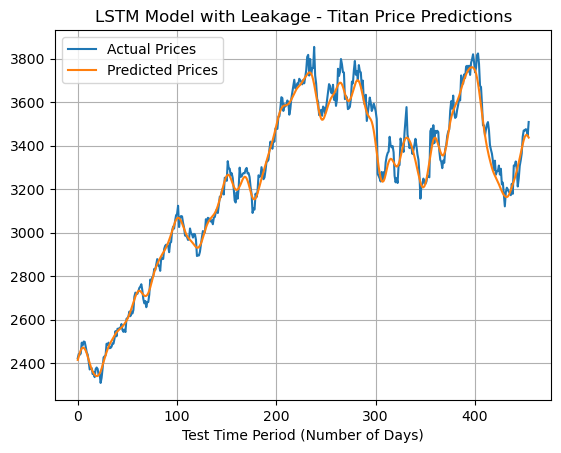

In [139]:
plt.plot(y_test_og_scale, label="Actual Prices")
plt.plot(y_pred_og_scale,label="Predicted Prices")
plt.legend()
plt.grid()
plt.xlabel("Test Time Period (Number of Days)")
plt.title("LSTM Model with Leakage - Titan Price Predictions")

## Step 2

## a. Now, I train my models models using a (non-anchored) walk forward method that exploits a train/test split with 500 observations in each set.

In [141]:
stock_prices_scaled

array([[0.        ],
       [0.00385413],
       [0.00697543],
       ...,
       [0.84973742],
       [0.84581803],
       [0.83114524]])

let us build features out of this data for our models.

In [144]:
prices_scaled = pd.DataFrame(stock_prices_scaled)
prices_scaled.columns = [['Close']]

In [146]:
prices_scaled["1d_lag"] = prices_scaled["Close"].shift(1)
prices_scaled["2d_mva"] = prices_scaled["Close"].rolling(2).mean()
prices_scaled["5d_mva"] = prices_scaled["Close"].rolling(5).mean()
prices_scaled["7d_mva"] = prices_scaled["Close"].rolling(7).mean()
prices_scaled["10d_mva"] = prices_scaled["Close"].rolling(10).mean()
prices_scaled["20d_mva"] = prices_scaled["Close"].rolling(10).mean()
prices_scaled["Target"] = prices_scaled["Close"].shift(-1)
prices_scaled.index = stock_data.index

In [148]:
prices_scaled.dropna(inplace=True)

In [150]:
X_scaled = prices_scaled[['Close', '1d_lag', '2d_mva','5d_mva', '7d_mva', '10d_mva', '20d_mva']]
y_scaled = prices_scaled[['Target']]

In [152]:
y_scaled

,Target
Date,
2017-01-13 00:00:00+05:30,0.007844
2017-01-16 00:00:00+05:30,0.007057
2017-01-17 00:00:00+05:30,0.008970
2017-01-18 00:00:00+05:30,0.010517
2017-01-19 00:00:00+05:30,0.007260
...,...
2024-12-20 00:00:00+05:30,0.870650
2024-12-23 00:00:00+05:30,0.858326
2024-12-24 00:00:00+05:30,0.849737


In [154]:
dates = X_scaled.index

In [160]:
for i in range(0, X_scaled.shape[0] - 500, 500):
    X_train_scaled = X_scaled.iloc[i: i + 500]
    X_test_scaled = X_scaled.iloc[i + 500: i + 1000]
    y_train_scaled = y_scaled.iloc[i: i + 500]
    y_test_scaled = y_scaled.iloc[i + 500: i + 1000]

    tf.keras.backend.clear_session()
    tf.random.set_seed(42)

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=hp_units_1, activation=act_fun, input_shape=(7,)))
    #model.add(tf.keras.layers.Dropout(n_dropout))
    model.add(tf.keras.layers.Dense(units=hp_units_2, activation=act_fun))
    #model.add(tf.keras.layers.Dropout(n_dropout))
    model.add(tf.keras.layers.Dense(units=hp_units_3, activation=act_fun))
    #model.add(tf.keras.layers.Dropout(n_dropout)
    model.add(tf.keras.layers.Dense(units=hp_units_4, activation=act_fun))
    model.add(tf.keras.layers.Dense(units=1)) #activation function

    hp_lr = 1e-4  # Learning rate
    adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)  # Adam optimizer
    model.compile(optimizer=adam, loss="mse", metrics=["mae"])

    es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    verbose=1,
    patience=20,
    restore_best_weights=True,)

    history = model.fit(
    X_train_scaled,
    y_train_scaled,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=0,
    callbacks = [es],
    )

    y_pred_scaled = model.predict(X_test_scaled)
    print(r2_score(y_pred_scaled, y_test_scaled["Target"].values))

C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 100.
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
0.7768180034047488


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 100.
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
-1.5343721630236424


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 27: early stopping
Restoring model weights from the end of the best epoch: 7.
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
0.8669256202001212


we get a good r2 score for the out-of-sample predictions on the last 500 days of the data.

In [171]:
y_test_og_scale = scaler.inverse_transform(np.array(y_test_scaled).reshape(-1, 1))
y_pred_og_scale = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

Text(0.5, 1.0, 'MLP Model with Leakage & Walf-Forward Validation - Titan Price Predictions for 500 Samples')

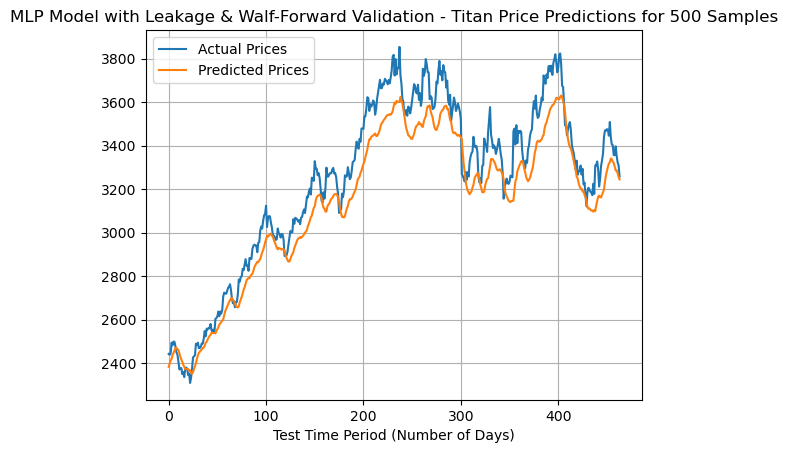

In [235]:
plt.plot(y_test_og_scale, label="Actual Prices")
plt.plot(y_pred_og_scale,label="Predicted Prices")
plt.legend()
plt.grid()
plt.xlabel("Test Time Period (Number of Days)")
plt.title("MLP Model with Leakage & Walf-Forward Validation - Titan Price Predictions for 500 Samples")

In [231]:
#MaxPro Trading Strategy -Profit per unit stock
max_index = y_pred_og_scale.argmax()
min_index = y_pred_og_scale.argmin()

print("Profit: ", float(y_test_og_scale[max_index]) - float(y_test_og_scale[min_index]))

Profit:  1400.5063476562495


C:\Users\susha\AppData\Local\Temp\ipykernel_52360\3666589164.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Profit: ", float(y_test_og_scale[max_index]) - float(y_test_og_scale[min_index]))


Now, let us build the LSTM model and backtest it using the same walk-forward technique.

In [237]:
for i in range(0, X_scaled.shape[0] - 500, 500):
    X_train_scaled = X_scaled.iloc[i: i + 500]
    X_test_scaled = X_scaled.iloc[i + 500: i + 1000]
    y_train_scaled = y_scaled.iloc[i: i + 500]
    y_test_scaled = y_scaled.iloc[i + 500: i + 1000]

    tf.keras.backend.clear_session()
    tf.random.set_seed(42)

    model = Sequential()
    model.add(
    LSTM(
        units=128,
        return_sequences=True,
        activation="relu",
        input_shape=(X_train_scaled.shape[1], 1),
    ))

    model.add(LSTM(units=256, return_sequences=True, activation="tanh"))
    model.add(Dropout(n_dropout, seed=seed))
    model.add(LSTM(units=128, return_sequences=True, activation="tanh"))
    model.add(Dropout(n_dropout, seed=seed))
    model.add(LSTM(units=64, return_sequences=False, activation="tanh"))
    model.add(Dropout(n_dropout, seed=seed))
    model.add(Dense(64))
    model.add(Dense(1))

    hp_lr = 1e-4
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), loss="mean_absolute_error"
    )
    
    es = EarlyStopping(
        monitor="val_loss", mode="min", verbose=0, patience=15, restore_best_weights=True
    )
    
    # fit the models
    model.fit(
        X_train_scaled,
        y_train_scaled,
        validation_split=0.15,
        epochs=100,
        batch_size=64,
        verbose=0,
        callbacks=[es],
    )

    y_pred_scaled = model.predict(X_test_scaled)
    print(r2_score(y_pred_scaled, y_test_scaled["Target"].values))

C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step
0.9653900368148162


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step
-55.348614582533415


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step
0.9669618970155369


In [239]:
y_test_og_scale = scaler.inverse_transform(np.array(y_test_scaled).reshape(-1, 1))
y_pred_og_scale = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

Text(0.5, 1.0, 'LSTM Model with Leakage & Walf-Forward Validation - Titan Price Predictions for 500 Samples')

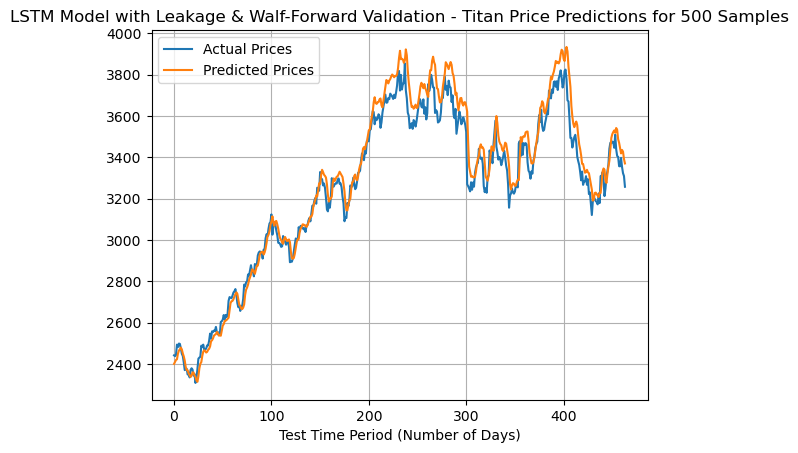

In [241]:
plt.plot(y_test_og_scale, label="Actual Prices")
plt.plot(y_pred_og_scale,label="Predicted Prices")
plt.legend()
plt.grid()
plt.xlabel("Test Time Period (Number of Days)")
plt.title("LSTM Model with Leakage & Walf-Forward Validation - Titan Price Predictions for 500 Samples")

In [243]:
#MaxPro Trading Strategy -Profit per unit stock
max_index = y_pred_og_scale.argmax()
min_index = y_pred_og_scale.argmin()

print("Profit: ", float(y_test_og_scale[max_index]) - float(y_test_og_scale[min_index]))

Profit:  1400.5063476562495


C:\Users\susha\AppData\Local\Temp\ipykernel_52360\2995148808.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Profit: ", float(y_test_og_scale[max_index]) - float(y_test_og_scale[min_index]))


## b. Now, I train my models models using a (non-anchored) walk forward method that exploits a train/test split with 100 observations in each set.

First, the MLP Model

In [245]:
for i in range(0, X_scaled.shape[0] - 500, 100):
    X_train_scaled = X_scaled.iloc[i: i + 500]
    X_test_scaled = X_scaled.iloc[i + 500: i + 600]
    y_train_scaled = y_scaled.iloc[i: i + 500]
    y_test_scaled = y_scaled.iloc[i + 500: i + 600]

    tf.keras.backend.clear_session()
    tf.random.set_seed(42)

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=hp_units_1, activation=act_fun, input_shape=(7,)))
    #model.add(tf.keras.layers.Dropout(n_dropout))
    model.add(tf.keras.layers.Dense(units=hp_units_2, activation=act_fun))
    #model.add(tf.keras.layers.Dropout(n_dropout))
    model.add(tf.keras.layers.Dense(units=hp_units_3, activation=act_fun))
    #model.add(tf.keras.layers.Dropout(n_dropout)
    model.add(tf.keras.layers.Dense(units=hp_units_4, activation=act_fun))
    model.add(tf.keras.layers.Dense(units=1)) #activation function

    hp_lr = 1e-4  # Learning rate
    adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)  # Adam optimizer
    model.compile(optimizer=adam, loss="mse", metrics=["mae"])

    es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    verbose=1,
    patience=20,
    restore_best_weights=True,)

    history = model.fit(
    X_train_scaled,
    y_train_scaled,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=0,
    callbacks = [es],
    )

    y_pred_scaled = model.predict(X_test_scaled)
    print(r2_score(y_pred_scaled, y_test_scaled["Target"].values))

C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 100.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
-2.244335624395824


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 99.
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/stepWARNING:tensorflow:6 out of the last 23 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002B1363C82C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0.698324160335678


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 100.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0.8649391352657152


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 100.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0.8162334356538025


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 100.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0.5531721682181607


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 100.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0.2548939556250913


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 100.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0.8241145735035014


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 100.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
-1.8125908996086677


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 100.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
0.8851502415353522


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 100.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0.7911401507771437


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 100.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0.8426900743512363


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 100.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
-0.20434362622429103


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 43: early stopping
Restoring model weights from the end of the best epoch: 23.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
-15.879154027254593


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 33: early stopping
Restoring model weights from the end of the best epoch: 13.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
-0.20090257084910967


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 100.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
0.8166540488209357


Here again, we see overfitting with r2 scores varing from >0.8 to negative ones

In [249]:
y_test_og_scale = scaler.inverse_transform(np.array(y_test_scaled).reshape(-1, 1))
y_pred_og_scale = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

Text(0.5, 1.0, 'MLP Model with Leakage & Walf-Forward Validation - Titan Price Predictions for 100 Samples')

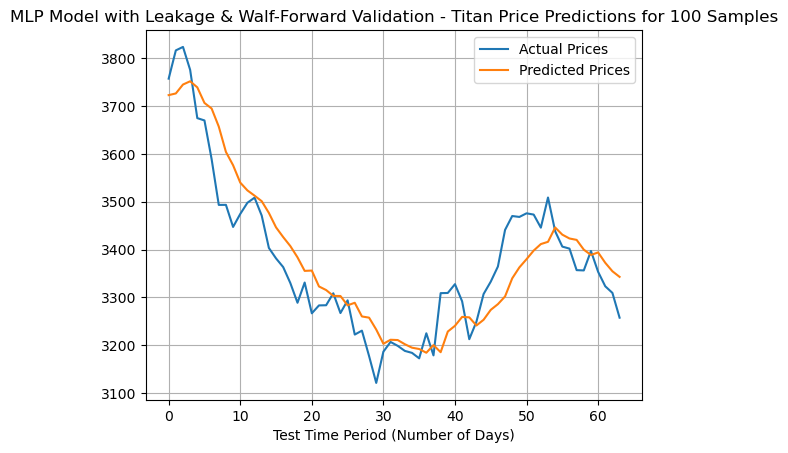

In [251]:
plt.plot(y_test_og_scale, label="Actual Prices")
plt.plot(y_pred_og_scale,label="Predicted Prices")
plt.legend()
plt.grid()
plt.xlabel("Test Time Period (Number of Days)")
plt.title("MLP Model with Leakage & Walf-Forward Validation - Titan Price Predictions for 100 Samples")

In [253]:
#MaxPro Trading Strategy -Profit per unit stock
max_index = y_pred_og_scale.argmax()
min_index = y_pred_og_scale.argmin()

print("Profit: ", float(y_test_og_scale[max_index]) - float(y_test_og_scale[min_index]))
print("Profit: ", float(y_pred_og_scale.max()) - float(y_pred_og_scale.min()))

Profit:  551.2499999999995
Profit:  568.050537109375


C:\Users\susha\AppData\Local\Temp\ipykernel_52360\2639383093.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Profit: ", float(y_test_og_scale[max_index]) - float(y_test_og_scale[min_index]))


Now, I build the leaky LSTM Model

In [256]:
for i in range(0, X_scaled.shape[0] - 500, 100):
    X_train_scaled = X_scaled.iloc[i: i + 500]
    X_test_scaled = X_scaled.iloc[i + 500: i + 600]
    y_train_scaled = y_scaled.iloc[i: i + 500]
    y_test_scaled = y_scaled.iloc[i + 500: i + 600]

    tf.keras.backend.clear_session()
    tf.random.set_seed(42)

    model = Sequential()
    model.add(
    LSTM(
        units=128,
        return_sequences=True,
        activation="relu",
        input_shape=(X_train_scaled.shape[1], 1),
    ))

    model.add(LSTM(units=256, return_sequences=True, activation="tanh"))
    model.add(Dropout(n_dropout, seed=seed))
    model.add(LSTM(units=128, return_sequences=True, activation="tanh"))
    model.add(Dropout(n_dropout, seed=seed))
    model.add(LSTM(units=64, return_sequences=False, activation="tanh"))
    model.add(Dropout(n_dropout, seed=seed))
    model.add(Dense(64))
    model.add(Dense(1))

    hp_lr = 1e-4
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), loss="mean_absolute_error"
    )
    
    es = EarlyStopping(
        monitor="val_loss", mode="min", verbose=0, patience=15, restore_best_weights=True
    )
    
    # fit the models
    model.fit(
        X_train_scaled,
        y_train_scaled,
        validation_split=0.15,
        epochs=100,
        batch_size=64,
        verbose=0,
        callbacks=[es],
    )

    y_pred_scaled = model.predict(X_test_scaled)
    print(r2_score(y_pred_scaled, y_test_scaled["Target"].values))

C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 304ms/step
0.9630728039619825


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 290ms/step
0.8732167483132618


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 287ms/step
-40.44312237810087


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 378ms/step
0.9301875042692964


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 374ms/step
0.9660347323327356


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 366ms/step
-82.78681200152647


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 285ms/step
-56.279237085230484


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 292ms/step
0.6250272345825572


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 294ms/step
0.9353228275716654


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 369ms/step
0.6782281771521168


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 304ms/step
0.9520905847709504


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step
-21.441563580792856


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 290ms/step
-13.093687685720084


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 283ms/step
-0.3284134671459711


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step 
0.8844144326665887


Yet again, we see overfitting with r2 scores varing from >0.8 to negative ones

In [259]:
y_test_og_scale = scaler.inverse_transform(np.array(y_test_scaled).reshape(-1, 1))
y_pred_og_scale = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

Text(0.5, 1.0, 'LSTM Model with Leakage & Walf-Forward Validation - Titan Price Predictions for 100 Samples')

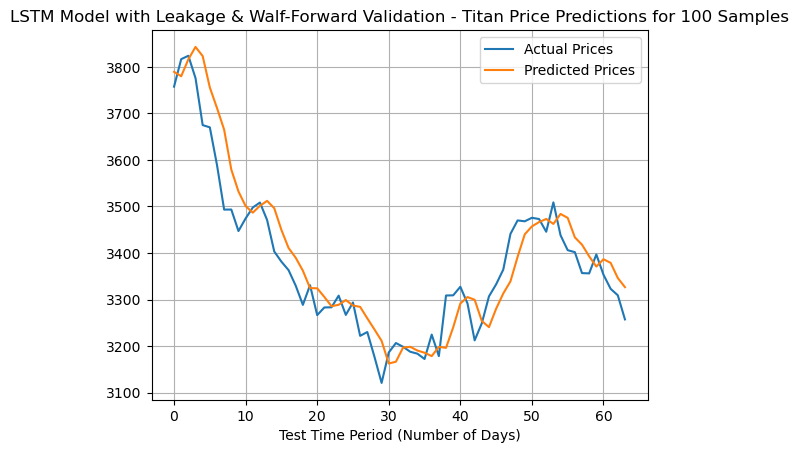

In [261]:
plt.plot(y_test_og_scale, label="Actual Prices")
plt.plot(y_pred_og_scale,label="Predicted Prices")
plt.legend()
plt.grid()
plt.xlabel("Test Time Period (Number of Days)")
plt.title("LSTM Model with Leakage & Walf-Forward Validation - Titan Price Predictions for 100 Samples")

In [263]:
#MaxPro Trading Strategy -Profit per unit stock
max_index = y_pred_og_scale.argmax()
min_index = y_pred_og_scale.argmin()

print("Profit: ", float(y_test_og_scale[max_index]) - float(y_test_og_scale[min_index]))
print("Profit: ", float(y_pred_og_scale.max()) - float(y_pred_og_scale.min()))

Profit:  589.6999511718745
Profit:  680.43603515625


C:\Users\susha\AppData\Local\Temp\ipykernel_52360\2639383093.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Profit: ", float(y_test_og_scale[max_index]) - float(y_test_og_scale[min_index]))


## Step 3

Now, the task is to repeat the computations in Step 2 but after alievating the data leakage issues in our model.

The data leakage issues are removed by:
1. Splitting the data into train and test sets, and then performing the scaling.

In [362]:
stock_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-01-02 00:00:00+05:30,315.502617,322.552127,312.193640,320.298218,656084,0.0,0.0
2017-01-03 00:00:00+05:30,327.060020,340.104062,325.285642,333.917725,2773103,0.0,0.0
2017-01-04 00:00:00+05:30,336.075709,347.153565,334.924782,344.947571,2371009,0.0,0.0
2017-01-05 00:00:00+05:30,345.762881,346.722002,340.919335,343.413025,1187872,0.0,0.0
2017-01-06 00:00:00+05:30,344.324119,348.160599,338.185756,340.679474,1089982,0.0,0.0
...,...,...,...,...,...,...,...
2024-12-23 00:00:00+05:30,3378.100098,3406.300049,3336.649902,3396.949951,691202,0.0,0.0
2024-12-24 00:00:00+05:30,3385.350098,3419.000000,3338.199951,3353.399902,485245,0.0,0.0
2024-12-26 00:00:00+05:30,3365.000000,3371.850098,3312.649902,3323.050049,637094,0.0,0.0


In [364]:
prices = pd.DataFrame(stock_data["Close"])

## a. Now, I train my models using a (non-anchored) walk forward method that exploits a train/test split with 500 observations in each set. I ensure no data leakage.

First, the MLP model

In [368]:
prices["1d_lag"] = prices["Close"].shift(1)
prices["2d_mva"] = prices["Close"].rolling(2).mean()
prices["5d_mva"] = prices["Close"].rolling(5).mean()
prices["7d_mva"] = prices["Close"].rolling(7).mean()
prices["10d_mva"] = prices["Close"].rolling(10).mean()
prices["20d_mva"] = prices["Close"].rolling(10).mean()
prices["Target"] = prices["Close"].shift(-1)
prices.index = stock_data.index

In [370]:
prices.dropna(inplace=True)

In [372]:
prices

,Close,1d_lag,2d_mva,5d_mva,7d_mva,10d_mva,20d_mva,Target
Date,,,,,,,,
2017-01-13 00:00:00+05:30,343.700714,348.832031,346.266373,345.062683,344.200845,340.856943,340.856943,348.016754
2017-01-16 00:00:00+05:30,348.016754,343.700714,345.858734,346.645233,344.858521,343.628796,343.628796,345.235413
2017-01-17 00:00:00+05:30,345.235413,348.016754,346.626083,346.357507,345.509369,344.760565,344.760565,351.997131
2017-01-18 00:00:00+05:30,351.997131,345.235413,348.616272,347.556409,347.208387,345.465521,345.465521,357.464142
2017-01-19 00:00:00+05:30,357.464142,351.997131,354.730637,349.282831,348.749830,346.870633,346.870633,345.954681
...,...,...,...,...,...,...,...,...
2024-12-20 00:00:00+05:30,3356.250000,3356.850098,3356.550049,3391.860010,3416.271449,3433.095020,3433.095020,3396.949951
2024-12-23 00:00:00+05:30,3396.949951,3356.250000,3376.599976,3383.610010,3409.300014,3425.970020,3425.970020,3353.399902
2024-12-24 00:00:00+05:30,3353.399902,3396.949951,3375.174927,3373.069971,3387.092843,3413.735010,3413.735010,3323.050049


In [374]:
X = prices[['Close', '1d_lag', '2d_mva','5d_mva', '7d_mva', '10d_mva', '20d_mva']]
y = prices[['Target']]

In [376]:
for i in range(0, X.shape[0] - 500, 500):
    X_train = X.iloc[i: i + 500]
    X_test = X.iloc[i + 500: i + 1000]
    y_train = y.iloc[i: i + 500]
    y_test = y.iloc[i + 500: i + 1000]

    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    y_train_scaled = scaler.fit_transform(y_train)
    y_test_scaled = scaler.transform(y_test)
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(42)

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=hp_units_1, activation=act_fun, input_shape=(7,)))
    #model.add(tf.keras.layers.Dropout(n_dropout))
    model.add(tf.keras.layers.Dense(units=hp_units_2, activation=act_fun))
    #model.add(tf.keras.layers.Dropout(n_dropout))
    model.add(tf.keras.layers.Dense(units=hp_units_3, activation=act_fun))
    #model.add(tf.keras.layers.Dropout(n_dropout)
    model.add(tf.keras.layers.Dense(units=hp_units_4, activation=act_fun))
    model.add(tf.keras.layers.Dense(units=1)) #activation function

    hp_lr = 1e-4  # Learning rate
    adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)  # Adam optimizer
    model.compile(optimizer=adam, loss="mse", metrics=["mae"])

    es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    verbose=1,
    patience=20,
    restore_best_weights=True,)

    history = model.fit(
    X_train_scaled,
    y_train_scaled,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=0,
    callbacks = [es],
    )

    y_pred_scaled = model.predict(X_test_scaled)
    print(r2_score(y_pred_scaled, y_test_scaled))

C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 100.
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
0.9433453820817025


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 98.
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
0.8781716847014015


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 100.
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
0.9745617706965183


Here, the r2 values are good and no overfitting is seen.

In [379]:
y_test_og_scale = scaler.inverse_transform(y_test_scaled.reshape(-1, 1))
y_pred_og_scale = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

Text(0.5, 1.0, 'MLP Model with No Leakage & Walk-Forward Validation - Titan Price Predictions for 500 Samples')

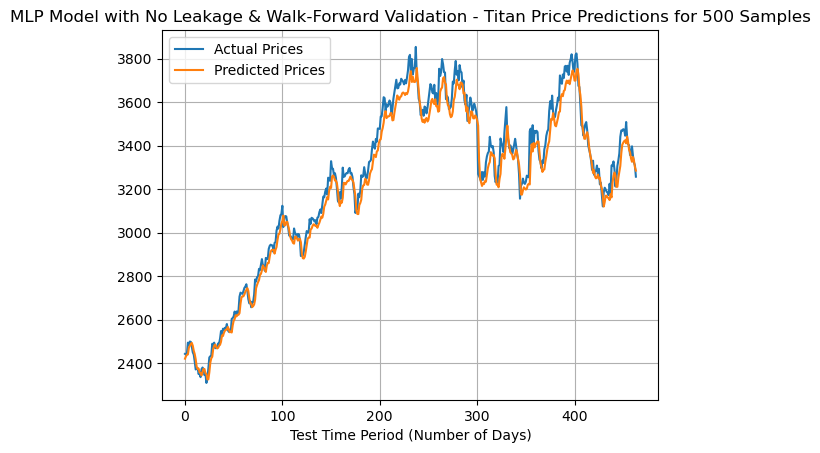

In [381]:
plt.plot(y_test_og_scale, label="Actual Prices")
plt.plot(y_pred_og_scale,label="Predicted Prices")
plt.legend()
plt.grid()
plt.xlabel("Test Time Period (Number of Days)")
plt.title("MLP Model with No Leakage & Walk-Forward Validation - Titan Price Predictions for 500 Samples")

In [383]:
#MaxPro Trading Strategy -Profit per unit stock
max_index = y_pred_og_scale.argmax()
min_index = y_pred_og_scale.argmin()

print("Profit: ", float(y_test_og_scale[max_index]) - float(y_test_og_scale[min_index]))
print("Profit: ", float(y_pred_og_scale.max()) - float(y_pred_og_scale.min()))

Profit:  1348.12255859375
Profit:  1431.694091796875


C:\Users\susha\AppData\Local\Temp\ipykernel_52360\2639383093.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Profit: ", float(y_test_og_scale[max_index]) - float(y_test_og_scale[min_index]))


Now, let us build the LSTM model and backtest it using the same walk-forward technique.

In [385]:
for i in range(0, X.shape[0] - 500, 500):
    X_train = X.iloc[i: i + 500]
    X_test = X.iloc[i + 500: i + 1000]
    y_train = y.iloc[i: i + 500]
    y_test = y.iloc[i + 500: i + 1000]

    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    y_train_scaled = scaler.fit_transform(y_train)
    y_test_scaled = scaler.transform(y_test)

    tf.keras.backend.clear_session()
    tf.random.set_seed(42)

    model = Sequential()
    model.add(
    LSTM(
        units=128,
        return_sequences=True,
        activation="relu",
        input_shape=(X_train_scaled.shape[1], 1),
    ))

    model.add(LSTM(units=256, return_sequences=True, activation="tanh"))
    model.add(Dropout(n_dropout, seed=seed))
    model.add(LSTM(units=128, return_sequences=True, activation="tanh"))
    model.add(Dropout(n_dropout, seed=seed))
    model.add(LSTM(units=64, return_sequences=False, activation="tanh"))
    model.add(Dropout(n_dropout, seed=seed))
    model.add(Dense(64))
    model.add(Dense(1))

    hp_lr = 1e-4
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), loss="mean_absolute_error"
    )
    
    es = EarlyStopping(
        monitor="val_loss", mode="min", verbose=0, patience=15, restore_best_weights=True
    )
    
    # fit the models
    model.fit(
        X_train_scaled,
        y_train_scaled,
        validation_split=0.15,
        epochs=100,
        batch_size=64,
        verbose=0,
        callbacks=[es],
    )

    y_pred_scaled = model.predict(X_test_scaled)
    print(r2_score(y_pred_scaled, y_test_scaled))

C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step
0.94427577532659


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step
0.972423918664757


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step
0.9611309987683625


Here too, the r2 values are good and no overfitting is seen.

In [387]:
y_test_og_scale = scaler.inverse_transform(y_test_scaled.reshape(-1, 1))
y_pred_og_scale = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

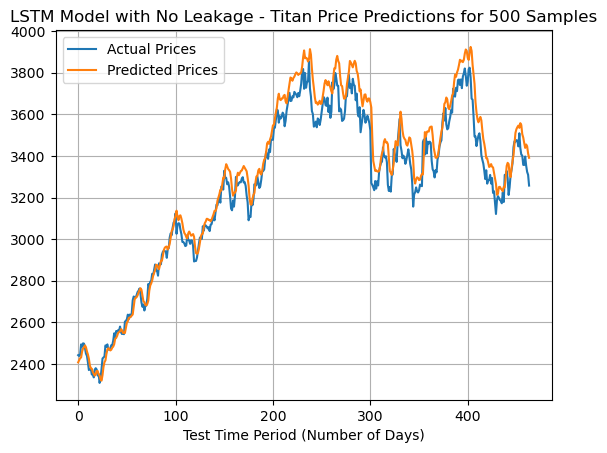

In [389]:
plt.plot(y_test_og_scale, label="Actual Prices")
plt.plot(y_pred_og_scale,label="Predicted Prices")
plt.legend()
plt.grid()
plt.xlabel("Test Time Period (Number of Days)")
plt.title("LSTM Model with No Leakage - Titan Price Predictions for 500 Samples")
plt.savefig("plot.png")

In [391]:
#MaxPro Trading Strategy -Profit per unit stock
max_index = y_pred_og_scale.argmax()
min_index = y_pred_og_scale.argmin()

print("Profit: ", float(y_test_og_scale[max_index]) - float(y_test_og_scale[min_index]))
print("Profit: ", float(y_pred_og_scale.max()) - float(y_pred_og_scale.min()))

Profit:  1400.5063476562505
Profit:  1603.714111328125


C:\Users\susha\AppData\Local\Temp\ipykernel_52360\2639383093.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Profit: ", float(y_test_og_scale[max_index]) - float(y_test_og_scale[min_index]))


## b. Now, I train my models models using a (non-anchored) walk forward method that exploits a train/test split with 100 observations in each set. I ensure no data leakage.

First, the MLP Model

In [395]:
for i in range(0, X.shape[0] - 500, 100):
    X_train = X.iloc[i: i + 500]
    X_test = X.iloc[i + 500: i + 600]
    y_train = y.iloc[i: i + 500]
    y_test = y.iloc[i + 500: i + 600]

    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    y_train_scaled = scaler.fit_transform(y_train)
    y_test_scaled = scaler.transform(y_test)
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(42)

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=hp_units_1, activation=act_fun, input_shape=(7,)))
    #model.add(tf.keras.layers.Dropout(n_dropout))
    model.add(tf.keras.layers.Dense(units=hp_units_2, activation=act_fun))
    #model.add(tf.keras.layers.Dropout(n_dropout))
    model.add(tf.keras.layers.Dense(units=hp_units_3, activation=act_fun))
    #model.add(tf.keras.layers.Dropout(n_dropout)
    model.add(tf.keras.layers.Dense(units=hp_units_4, activation=act_fun))
    model.add(tf.keras.layers.Dense(units=1)) #activation function

    hp_lr = 1e-4  # Learning rate
    adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)  # Adam optimizer
    model.compile(optimizer=adam, loss="mse", metrics=["mae"])

    es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    verbose=1,
    patience=20,
    restore_best_weights=True,)

    history = model.fit(
    X_train_scaled,
    y_train_scaled,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=0,
    callbacks = [es],
    )

    y_pred_scaled = model.predict(X_test_scaled)
    print(r2_score(y_pred_scaled, y_test_scaled))

C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 99.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
0.9319840125204902


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 96.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
0.6182158970490839


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 100.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
0.930548395660045


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 93: early stopping
Restoring model weights from the end of the best epoch: 73.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0.9412789696391066


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 100.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0.9523913355763226


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 99.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0.8924741502330183


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 97.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
0.9071617473281064


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 100.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
0.23764046306832265


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 98.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0.9408241884371034


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 100.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
0.8495141490364448


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 82.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0.970665760788974


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 99.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
0.7489405462989313


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 99.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
0.4617811934508216


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 100.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0.8450140173792784


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 100.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
0.861153287382596


Here, you can see that instances of overfitting are almost nil. A decent fit is obtained during most iterations.

In [398]:
y_test_og_scale = scaler.inverse_transform(y_test_scaled.reshape(-1, 1))
y_pred_og_scale = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

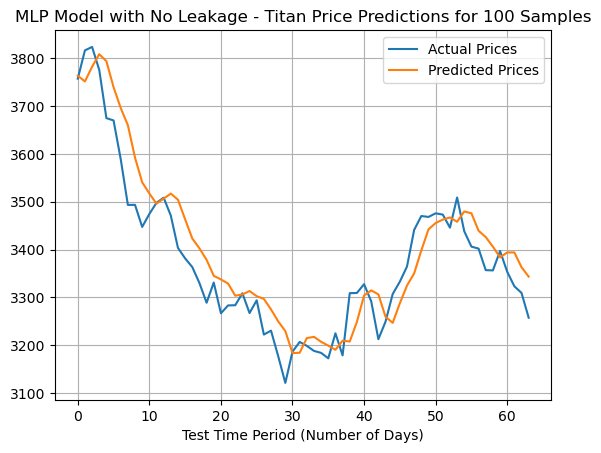

In [400]:
plt.plot(y_test_og_scale, label="Actual Prices")
plt.plot(y_pred_og_scale,label="Predicted Prices")
plt.legend()
plt.grid()
plt.xlabel("Test Time Period (Number of Days)")
plt.title("MLP Model with No Leakage - Titan Price Predictions for 100 Samples")
plt.savefig("plot.png")

In [402]:
#MaxPro Trading Strategy -Profit per unit stock
max_index = y_pred_og_scale.argmax()
min_index = y_pred_og_scale.argmin()

print("Profit: ", float(y_test_og_scale[max_index]) - float(y_test_og_scale[min_index]))
print("Profit: ", float(y_pred_og_scale.max()) - float(y_pred_og_scale.min()))

Profit:  589.6999511718741
Profit:  625.51416015625


C:\Users\susha\AppData\Local\Temp\ipykernel_52360\2639383093.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Profit: ", float(y_test_og_scale[max_index]) - float(y_test_og_scale[min_index]))


Now for the LSTM Model

In [405]:
for i in range(0, X.shape[0] - 500, 100):
    X_train = X.iloc[i: i + 500]
    X_test = X.iloc[i + 500: i + 600]
    y_train = y.iloc[i: i + 500]
    y_test = y.iloc[i + 500: i + 600]

    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    y_train_scaled = scaler.fit_transform(y_train)
    y_test_scaled = scaler.transform(y_test)

    tf.keras.backend.clear_session()
    tf.random.set_seed(42)

    model = Sequential()
    model.add(
    LSTM(
        units=128,
        return_sequences=True,
        activation="relu",
        input_shape=(X_train_scaled.shape[1], 1),
    ))

    model.add(LSTM(units=256, return_sequences=True, activation="tanh"))
    model.add(Dropout(n_dropout, seed=seed))
    model.add(LSTM(units=128, return_sequences=True, activation="tanh"))
    model.add(Dropout(n_dropout, seed=seed))
    model.add(LSTM(units=64, return_sequences=False, activation="tanh"))
    model.add(Dropout(n_dropout, seed=seed))
    model.add(Dense(64))
    model.add(Dense(1))

    hp_lr = 1e-4
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), loss="mean_absolute_error"
    )
    
    es = EarlyStopping(
        monitor="val_loss", mode="min", verbose=0, patience=15, restore_best_weights=True
    )
    
    # fit the models
    model.fit(
        X_train_scaled,
        y_train_scaled,
        validation_split=0.15,
        epochs=100,
        batch_size=64,
        verbose=0,
        callbacks=[es],
    )

    y_pred_scaled = model.predict(X_test_scaled)
    print(r2_score(y_pred_scaled, y_test_scaled))

C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 305ms/step
0.8819300615519046


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 270ms/step
0.868943214993234


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 270ms/step
0.9167158268229174


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 294ms/step
0.9189765985712341


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step
0.9170801361957145


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 319ms/step
0.9152152222126916


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 271ms/step
0.9744111337816747


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 298ms/step
0.6896445013663732


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 267ms/step
0.9349950050800065


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step
0.8359828454725163


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 269ms/step
0.9811071317743397


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step
0.795017395245784


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step
0.3787463592011513


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 273ms/step
0.681832855004477


C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step 
0.8831053187262929


Here again, there are no instances of overfitting!

In [408]:
y_test_og_scale = scaler.inverse_transform(y_test_scaled.reshape(-1, 1))
y_pred_og_scale = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

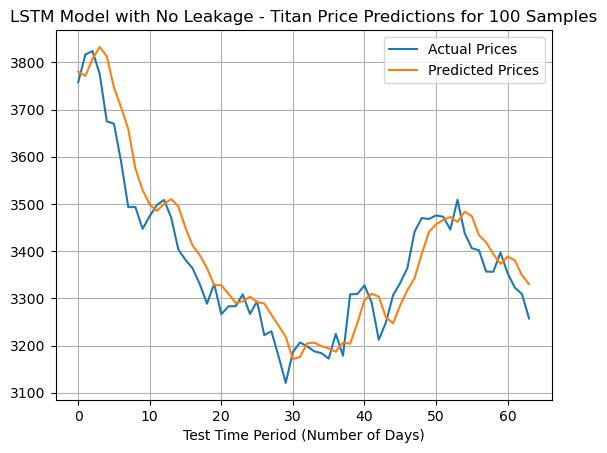

In [410]:
plt.plot(y_test_og_scale, label="Actual Prices")
plt.plot(y_pred_og_scale,label="Predicted Prices")
plt.legend()
plt.grid()
plt.xlabel("Test Time Period (Number of Days)")
plt.title("LSTM Model with No Leakage - Titan Price Predictions for 100 Samples")
plt.savefig("plot.png")

In [412]:
#MaxPro Trading Strategy -Profit per unit stock
max_index = y_pred_og_scale.argmax()
min_index = y_pred_og_scale.argmin()

print("Profit: ", float(y_test_og_scale[max_index]) - float(y_test_og_scale[min_index]))
print("Profit: ", float(y_pred_og_scale.max()) - float(y_pred_og_scale.min()))

Profit:  589.6999511718741
Profit:  661.227783203125


C:\Users\susha\AppData\Local\Temp\ipykernel_52360\2639383093.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Profit: ", float(y_test_og_scale[max_index]) - float(y_test_og_scale[min_index]))
